In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Modele simple

In [2]:
nb_actifs = 20
nb_dates = 256 * 5

idx = pd.Index(np.arange(nb_actifs))

mu = pd.Series(0.05,index=idx)
vols = pd.Series(0.2,index=idx)
correl = 0.7

covar = np.diag(vols) @ pd.DataFrame(correl * np.ones((nb_actifs,nb_actifs)) + (1-correl) * np.eye(nb_actifs),index=idx,columns=idx) @ np.diag(vols)
A = np.linalg.cholesky(covar)

rdts_observes = mu/256 + pd.DataFrame(np.random.randn(nb_dates,nb_actifs)) @ A.T / 16

In [3]:
mu_estime = rdts_observes.mean() * 256
covar_estimee = rdts_observes.cov() * 256
alloc_optimale_in_sample = pd.DataFrame(np.linalg.inv(covar_estimee),index=idx,columns=idx) @ mu_estime

Sharpe = 2.1650001420507703


<Axes: >

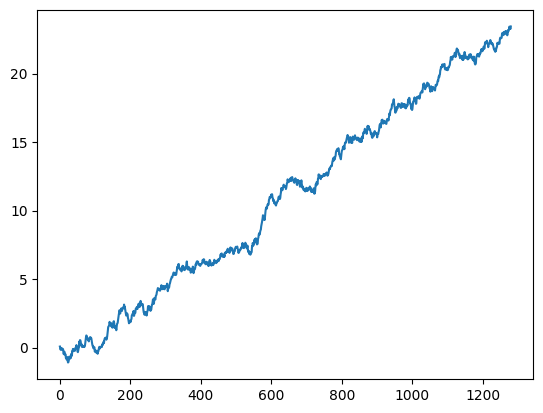

In [4]:
pnl_in_sample = rdts_observes @ alloc_optimale_in_sample
print('Sharpe = ' + str(pnl_in_sample.mean()/pnl_in_sample.std()*16))
pnl_in_sample.cumsum().plot()

In [5]:
nb_nouvelles_dates = 256

Sharpe = 0.5145209660040266


<Axes: >

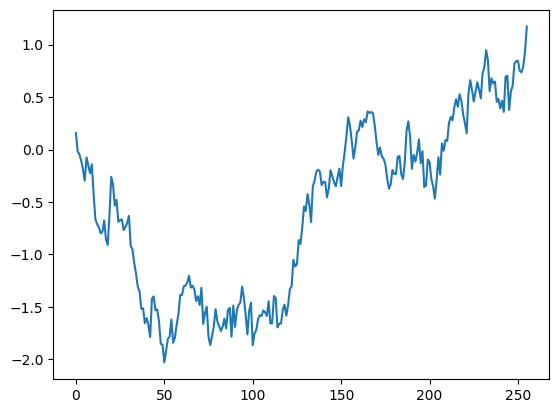

In [6]:
nouveaux_rdts = mu/256 + pd.DataFrame(np.random.randn(nb_nouvelles_dates,nb_actifs)) @ A.T / 16
pnl_out_sample = nouveaux_rdts @ alloc_optimale_in_sample
print('Sharpe = ' + str(pnl_out_sample.mean()/pnl_out_sample.std()*16))
pnl_out_sample.cumsum().plot()

In [7]:
nb_simu = 1000
pnls_out_sample = pd.DataFrame(mu @ alloc_optimale_in_sample /256 + (np.random.randn(nb_simu,nb_nouvelles_dates,nb_actifs) @ A.T @ alloc_optimale_in_sample.values/ 16)).T

In [8]:
sharpes_out_sample = pnls_out_sample.mean() / pnls_out_sample.std() * 16
sharpes_out_sample.describe()

count    1000.000000
mean        0.106015
std         1.070291
min        -3.119712
25%        -0.611049
50%         0.103843
75%         0.823352
max         3.962242
dtype: float64

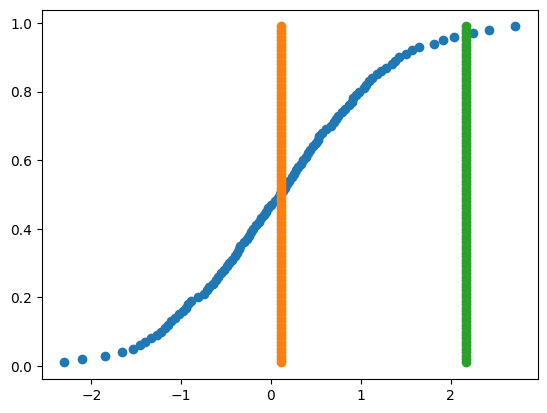

In [9]:
quantiles = sharpes_out_sample.quantile(np.arange(0.01,1.0,0.01)).reset_index().rename({'index':'proba',0:'quantile'},axis=1)
plt.scatter(quantiles['quantile'],quantiles['proba'])
plt.scatter(quantiles['quantile']*0 + sharpes_out_sample.mean(),quantiles['proba'])
plt.scatter(quantiles['quantile']*0 + pnl_in_sample.mean()/pnl_in_sample.std()*16,quantiles['proba'])

# Modele plus avance

In [10]:
nb_signals = 100
nb_dates_in_sample = 1300
nb_dates_out_sample = 260
nb_assets = 80

vol_assets = 0.2/16
correl_assets = 0.8

# vol_signals = 1.0
# correl_signals = 0.0

vol_signals = 0.2/16
correl_signals = 0.8

signal_to_noise = 0.001

rank_betas = 5

cov_assets = vol_assets**2 * pd.DataFrame(correl_assets * np.ones((nb_assets,nb_assets)) + (1-correl_assets)*np.eye(nb_assets))
cov_signals = vol_signals**2 * pd.DataFrame(correl_signals * np.ones((nb_signals,nb_signals)) + (1-correl_signals)*np.eye(nb_signals))

betas = pd.DataFrame(np.random.randn(nb_signals,nb_assets))
betas *= np.sqrt(signal_to_noise * np.trace(cov_assets) / np.trace(betas.T @ cov_signals @ betas))
u,d,v = np.linalg.svd(betas)
betas = pd.concat([pd.DataFrame(d[k] * np.outer(u[:,k],v[k,:]),index=betas.index,columns=betas.columns) for k in range(rank_betas)],keys=range(rank_betas)).groupby(level=1).sum()
betas *= np.sqrt(signal_to_noise * np.trace(cov_assets) / np.trace(betas.T @ cov_signals @ betas))
cov_noise = cov_assets - betas.T @ cov_signals @ betas
d,P = np.linalg.eigh(cov_noise)
cov_noise = pd.DataFrame(P @ np.diag(np.maximum(d,1e-10)) @ P.T)
print('signal to noise = ' + str(np.round(np.trace(betas.T @ cov_signals @ betas) / np.trace(cov_assets),3)))

sqrt_cov_assets = np.linalg.cholesky(cov_assets)
sqrt_cov_signals = np.linalg.cholesky(cov_signals)
sqrt_cov_noise = np.linalg.cholesky(cov_noise)

signal to noise = 0.001


3.374589684610921
-0.1950481281126299


<Axes: >

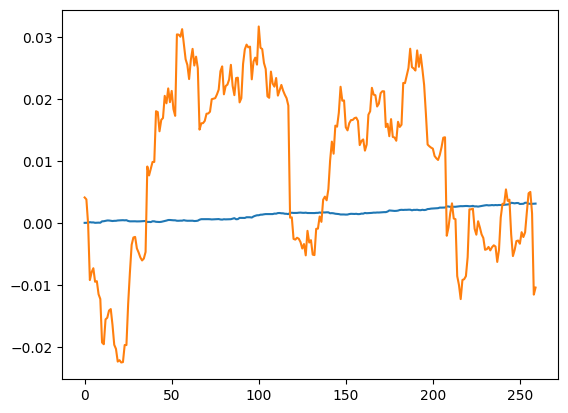

In [13]:
signals = pd.DataFrame(np.random.randn(nb_dates_in_sample,nb_signals) @ sqrt_cov_signals.T)
noise = pd.DataFrame(np.random.randn(nb_dates_in_sample,nb_assets) @ sqrt_cov_noise.T)
assets = signals @ betas+noise

signals_os = pd.DataFrame(np.random.randn(nb_dates_out_sample,nb_signals) @ sqrt_cov_signals.T)
noise_os = pd.DataFrame(np.random.randn(nb_dates_out_sample,nb_assets) @ sqrt_cov_noise.T)
assets_os = signals_os @ betas+noise_os

betas_ols = pd.DataFrame((np.linalg.inv(signals.T @ signals) @ signals.T @ assets).values,index=betas.index,columns=betas.columns)

w_theo = signals_os @ betas
pnl_theo = (w_theo * assets_os).sum(axis=1)

w_ols = signals_os @ betas_ols
pnl_ols = (w_ols * assets_os).sum(axis=1)

print(pnl_theo.mean()/pnl_theo.std()*16)
print(pnl_ols.mean()/pnl_ols.std()*16)

pnl_theo.cumsum().plot()
pnl_ols.cumsum().plot()

In [14]:
sharpes = {}
costs_break_even = {}
for i in range(1000):
    signals = pd.DataFrame(np.random.randn(nb_dates_in_sample,nb_signals) @ sqrt_cov_signals.T)
    noise = pd.DataFrame(np.random.randn(nb_dates_in_sample,nb_assets) @ sqrt_cov_noise.T)
    assets = signals @ betas+noise

    signals_os = pd.DataFrame(np.random.randn(nb_dates_out_sample,nb_signals) @ sqrt_cov_signals.T)
    noise_os = pd.DataFrame(np.random.randn(nb_dates_out_sample,nb_assets) @ sqrt_cov_noise.T)
    assets_os = signals_os @ betas+noise_os

    betas_ols = pd.DataFrame((np.linalg.inv(signals.T @ signals) @ signals.T @ assets).values,index=betas.index,columns=betas.columns)

    w_theo = signals_os @ betas
    pnl_theo = (w_theo * assets_os).sum(axis=1)

    w_ols = signals_os @ betas_ols
    pnl_ols = (w_ols * assets_os).sum(axis=1)

    sharpes[('theo',i)] = pnl_theo.mean()/pnl_theo.std()*16
    sharpes[('ols',i)] = pnl_ols.mean()/pnl_ols.std()*16

sharpes = pd.Series(sharpes).reset_index().rename({'level_0':'method','level_1':'simu',0:'sharpe'},axis=1)

In [17]:
pivot = sharpes.pivot_table(index='simu',columns='method')['sharpe']
means = pivot.mean()
quantiles = pivot.quantile(np.arange(0.01,1.0,0.01))

Text(0.5, 1.0, 'beta theo')

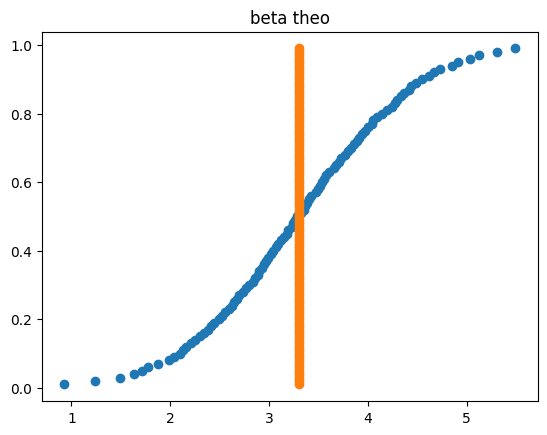

In [18]:
plt.scatter(quantiles['theo'],quantiles.index)
plt.scatter(quantiles['theo']*0+means['theo'],quantiles.index)
plt.title('beta theo')

Text(0.5, 1.0, 'beta ols')

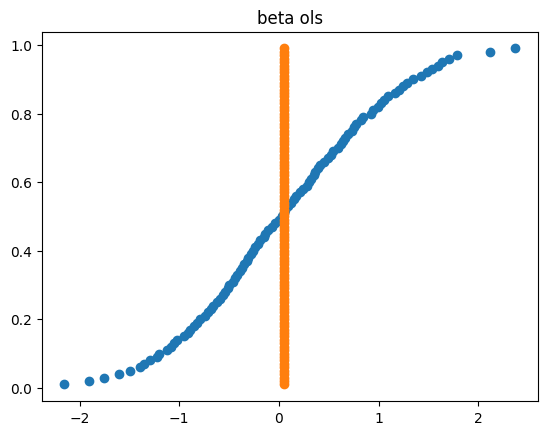

In [19]:
plt.scatter(quantiles['ols'],quantiles.index)
plt.scatter(quantiles['ols']*0+means['ols'],quantiles.index)
plt.title('beta ols')